In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmasher as cmr
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [4]:
df=pd.read_csv("IDD.csv",header=None)
ID=df[(df[0]>="760011-99999")&(df[0]<="780160-13601")] 
ID1=ID[0].str.split(pat="-", expand=True) #Separando 
ID["ID"]=ID1[0].astype(int)

esta=pd.read_fwf("ID.txt",header=None)
p=esta[1]
filtered_df = ID[(ID["ID"]).isin(p)]
filtered_df #Encontrando los datos de las estaciones que ocupamos
lat=filtered_df[2].values
lon=filtered_df[3].values
ele=filtered_df[4].values

#Agregando la elevación al dataframe
esta["elevacion"]=ele
esta["Lat"]=lat
esta["Lon"]=lon
esta["Lugar"]=filtered_df[1].values

/tmp/ipykernel_174893/1060579645.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ID["ID"]=ID1[0].astype(int)


In [5]:
#Cargando los datos de TW, SH y T
da_list=[]
for i,ii in enumerate(esta[1]):
    datos=xr.open_dataset(f"/home/andreagvc/data/ERA/ERA/Datos_HAD/{ii}99999_estadisticos.nc")
    datos=datos.assign_coords(estacion=ii)
    datos=datos.expand_dims('estacion')
    da_list.append(datos)
seas=xr.concat(da_list,dim='estacion')

In [6]:
#Cargando los datos de los clústers
cluster=pd.read_csv("clustering_Had.csv")

In [7]:
#Separando cada clúster
cluster0=cluster.loc[cluster.cluster==0]
cluster1=cluster.loc[cluster.cluster==1]

In [8]:
#Seleccionamos el id para el clúster 0, costero
Id=cluster0["ID"]
#Seleccionamos id para el clúster 1,continental
Id1=cluster1["ID"]

#Seleccionamos dichos ID dentro de todos nuestros datos
Datos=seas.where(seas.estacion.isin(Id),drop=True) #Cluster0
Datos1=seas.where(seas.estacion.isin(Id1),drop=True) #Cluster1


In [9]:
#Recortando que los años a analizar es de 1979-2023

#Regresión lineal por variable
trend_all=seas[["Tmax","SHmax","Twmax"]].where(Datos[["Tmax","SHmax","Twmax"]].time.dt.year>=1979,drop=True)
Tiempoall=trend_all.resample(time="YE").mean().time.dt.year
tmaxall=trend_all.Tmax.resample(time="YE").mean()
shmaxall=trend_all.SHmax.resample(time="YE").mean()
twmaxall=trend_all.Twmax.resample(time="YE").mean()

trend_t_all=np.array(tmaxall.mean("estacion"))
trend_sh_all=np.array(shmaxall.mean("estacion"))
trend_tw_all=np.array(twmaxall.mean("estacion"))

# Añadir una constante para el término de intersección en el modelo
X = sm.add_constant(np.float64(Tiempoall))

# Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
model_t_all = sm.OLS(trend_t_all, X).fit()
model_sh_all=sm.OLS(trend_sh_all*1000, X).fit()
model_tw_all=sm.OLS(trend_tw_all, X).fit()

#Regresión lineal por clúster
#Cluster0
trend_clus0=Datos[["Tmax","SHmax","Twmax"]].where(Datos[["Tmax","SHmax","Twmax"]].time.dt.year>=1979,drop=True)
Tiempo0=trend_clus0.resample(time="YE").mean().time.dt.year
tmax_clus0=trend_clus0.Tmax.resample(time="YE").mean()
shmax_clus0=trend_clus0.SHmax.resample(time="YE").mean()
twmax_clus0=trend_clus0.Twmax.resample(time="YE").mean()

# Añadir una constante para el término de intersección en el modelo
X1 = sm.add_constant(np.float64(Tiempo0))

trend_t_clus0=np.array(tmax_clus0.mean("estacion"))
trend_sh_clus0=np.array(shmax_clus0.mean("estacion"))
trend_tw_clus0=np.array(twmax_clus0.mean("estacion"))

# Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
model_t_clus0 = sm.OLS(trend_t_clus0, X1).fit()
model_sh_clus0=sm.OLS(trend_sh_clus0*1000, X1).fit()
model_tw_clus0=sm.OLS(trend_tw_clus0, X1).fit()

#Cluster1
trend_clus1=Datos1[["Tmax","SHmax","Twmax"]].where(Datos1[["Tmax","SHmax","Twmax"]].time.dt.year>=1979,drop=True)
Tiempo1=trend_clus1.resample(time="YE").mean().time.dt.year
tmax_clus1=trend_clus1.Tmax.resample(time="YE").mean()
shmax_clus1=trend_clus1.SHmax.resample(time="YE").mean()
twmax_clus1=trend_clus1.Twmax.resample(time="YE").mean()


trend_t_clus1=np.array(tmax_clus1.mean("estacion"))
trend_sh_clus1=np.array(shmax_clus1.mean("estacion"))
trend_tw_clus1=np.array(twmax_clus1.mean("estacion"))

# Añadir una constante para el término de intersección en el modelo
X2 = sm.add_constant(np.float64(Tiempo1))

# Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
model_t_clus1  = sm.OLS(trend_t_clus1, X2).fit()
model_sh_clus1 =sm.OLS(trend_sh_clus1*1000, X2).fit()
model_tw_clus1 =sm.OLS(trend_tw_clus1 ,X2).fit()

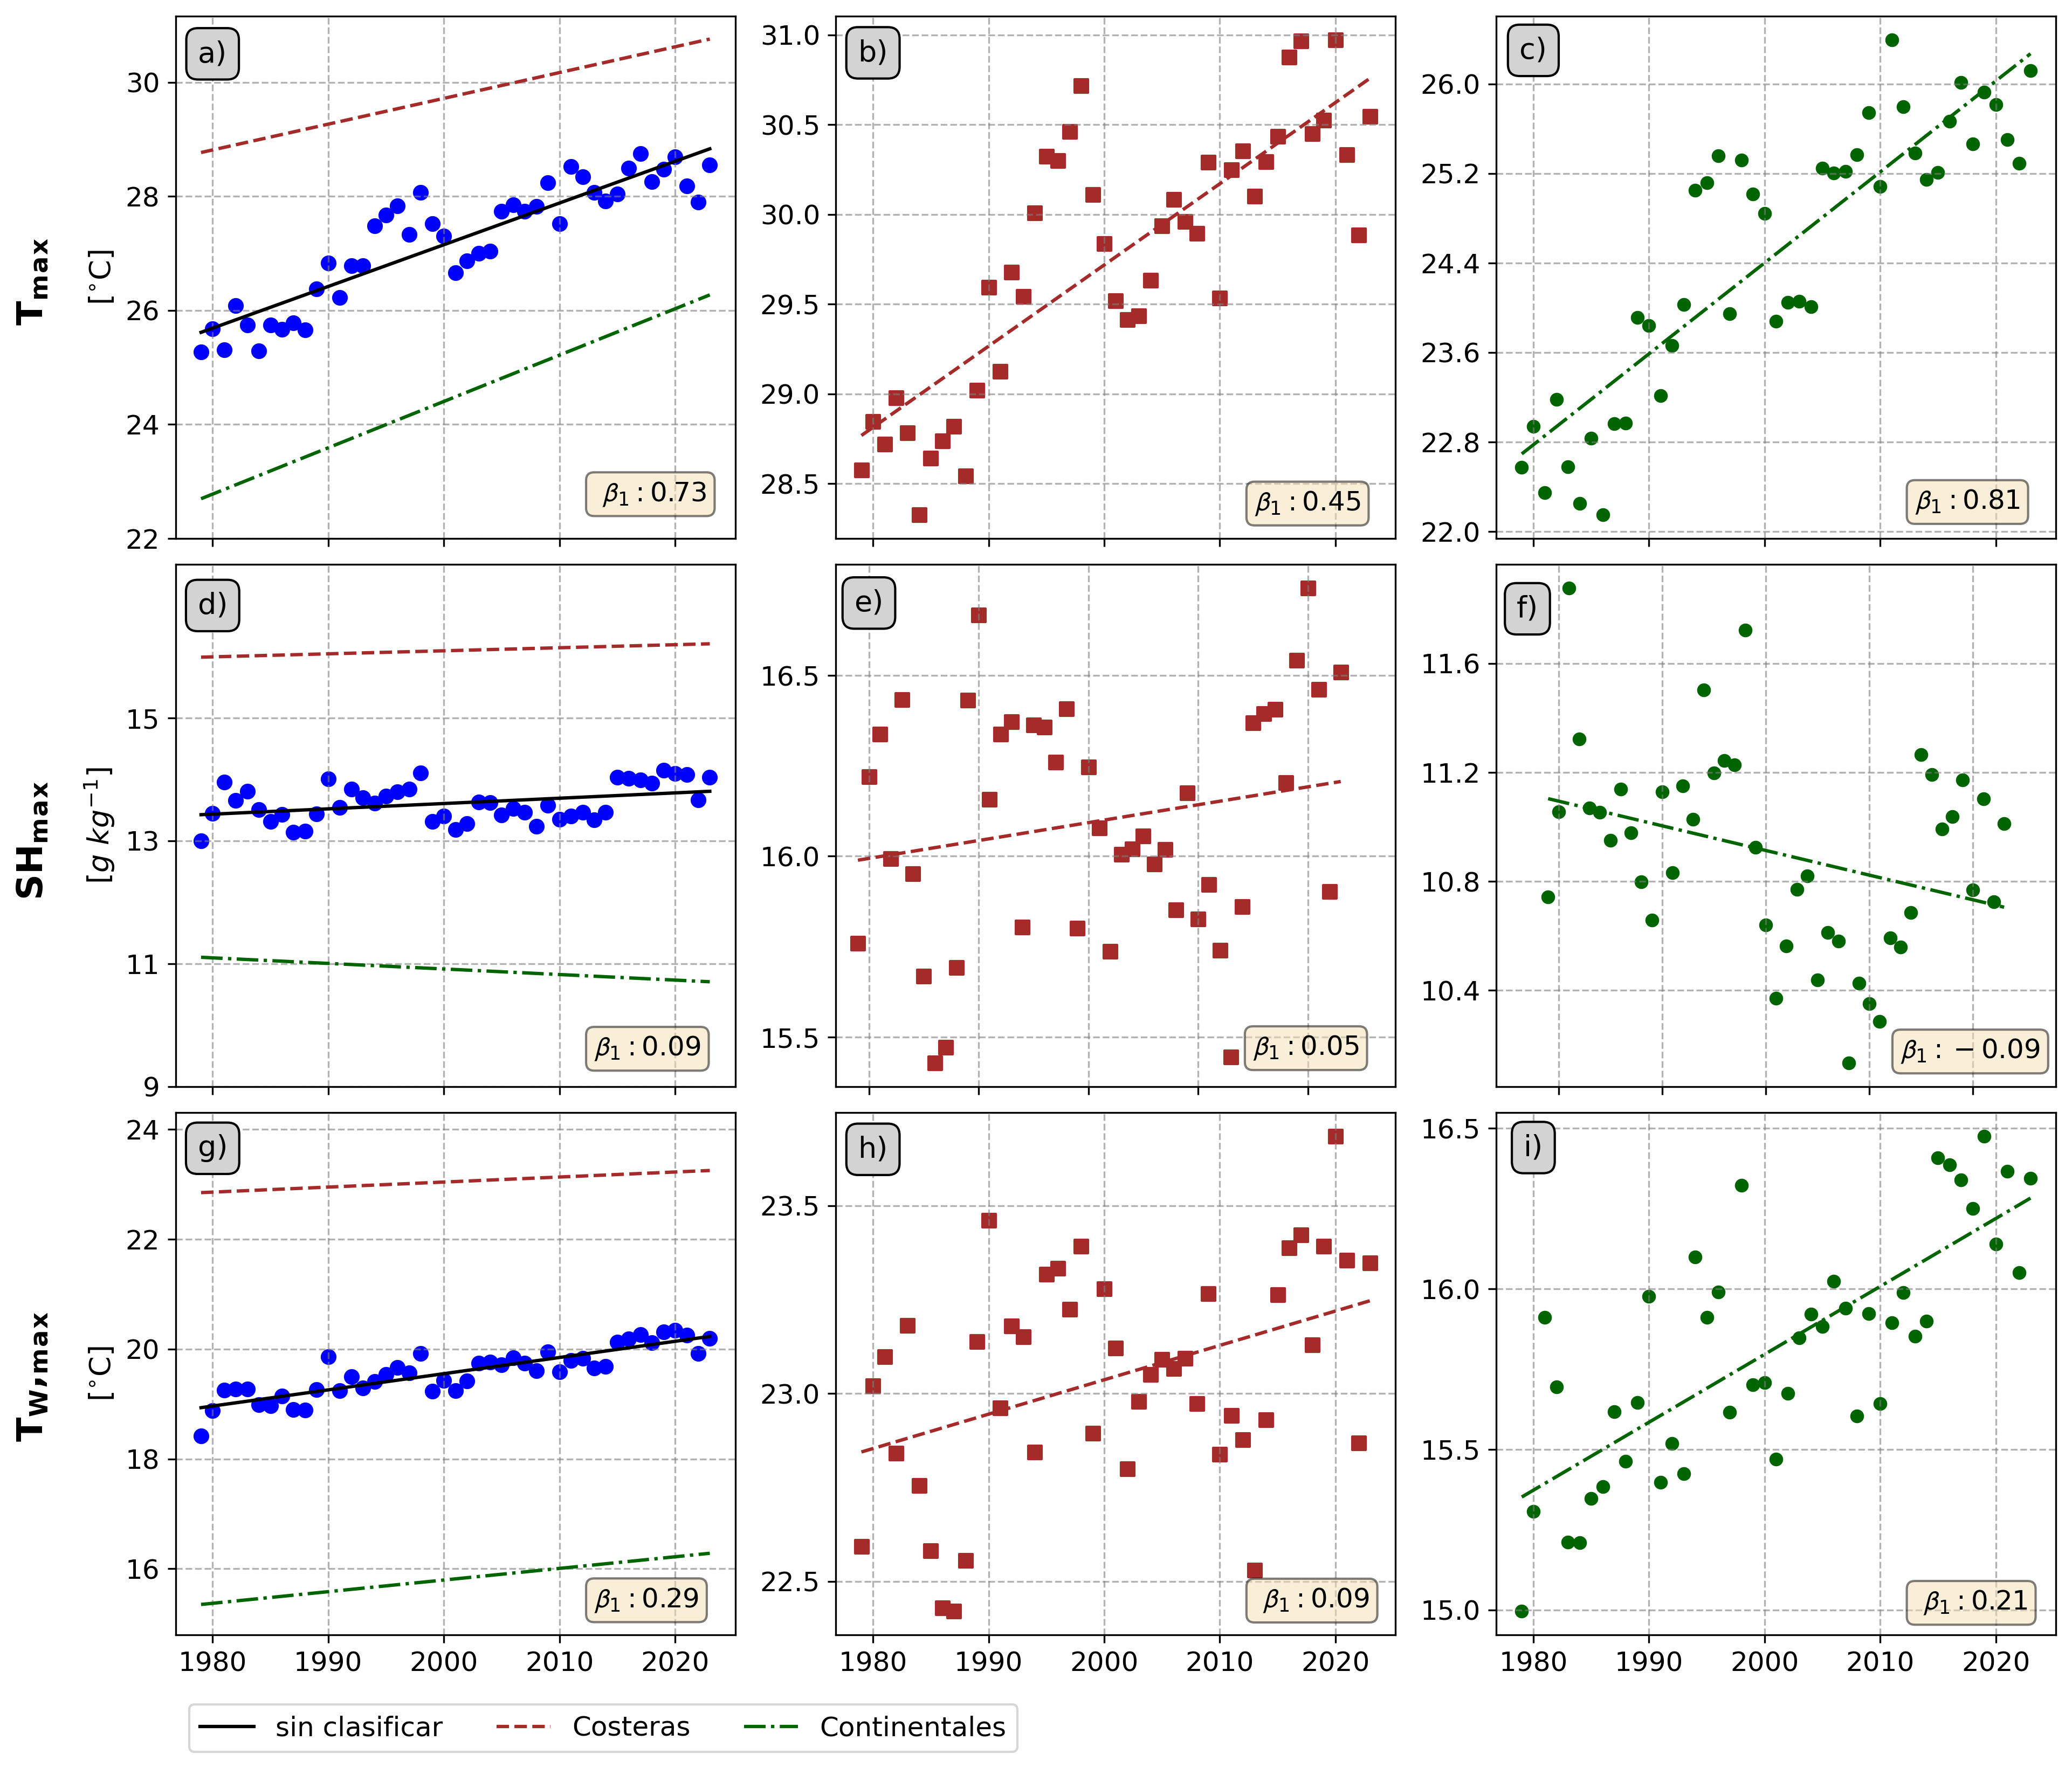

In [13]:
#Graficando las líneas de regresión

labels=["[$^{\circ}$C]","[$g$ $kg^{-1}$]","[$^{\circ}$C]"]
Temp=[model_t_all,model_t_clus0,model_t_clus1]
SH=[model_sh_all,model_sh_clus0,model_sh_clus1]
TW=[model_tw_all,model_tw_clus0,model_tw_clus1]
y=[trend_t_all,trend_t_clus0,trend_t_clus1]
y1=[trend_sh_all,trend_sh_clus0,trend_sh_clus1]
y2=[trend_tw_all,trend_tw_clus0,trend_tw_clus1]
label=["C0","C1"]
color=["brown","darkgreen"]
linestyle=["--","-."]
title=["b)","c)"]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(15, 13),dpi=300)
n=1
for i,ii in enumerate(Temp):
    plt.subplot(3,3,n)
    if n==1:
        plt.scatter(Tiempoall,y[i], color='blue')
       
        plt.plot(Tiempoall, ii.predict(X), color='black', label='All')
        plt.plot(Tiempoall, Temp[n].predict(X), color='brown', label='Costeras',linestyle="--")
        plt.plot(Tiempoall, Temp[n+1].predict(X), color='darkgreen', label='Continentales',linestyle="-.")
       
        plt.text(1980, 30.5, "a)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
       
        plt.ylabel(labels[n-1],fontsize=13)
       
        plt.text(1966, 26.5, r'$\mathbf{T}$$\mathbf{_m}$$\mathbf{_a}$$\mathbf{_x}$',fontsize=16, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor')
        plt.xticks(color="white",fontsize=12)
        plt.yticks(np.arange(22,31,2),fontsize=12)
        
        plt.text(2013,22.65,(f" $\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
       
     
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        n=n+1
    else:
        plt.subplot(3,3,n)
        
        if n==2:
            colors="brown"
            marker="s"
            ss=None
            
            plt.text(1980, 30.9, "b)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        else:
            colors='darkgreen'
            marker="."
            ss=105
            plt.yticks(np.arange(22,27,0.8))
            plt.text(1980, 26.3, "c)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        plt.scatter(Tiempoall,y[i] , color=colors, marker=marker, label='Datos',s=ss)
        plt.plot(Tiempoall, ii.predict(X), color=colors,linestyle=linestyle[n-2], label=label[n-2])
        plt.xticks(color="white",fontsize=12)
        plt.yticks(fontsize=12)
        
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        if n==3:
            plt.text(2013,22.2,(f"$\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
        else:
            plt.text(2013,28.35,(f"$\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
        n=n+1
Temp=[model_t_all,model_t_clus0,model_t_clus1]
SH=[model_sh_all,model_sh_clus0,model_sh_clus1]
TW=[model_tw_all,model_tw_clus0,model_tw_clus1]
y=[trend_t_all,trend_t_clus0,trend_t_clus1]
y1=[trend_sh_all,trend_sh_clus0,trend_sh_clus1]
y2=[trend_tw_all,trend_tw_clus0,trend_tw_clus1]
label=["C0","C1"]
color=["black","brown"]
linestyle=["--","-."]

n=4
p=0
for i,ii in enumerate(SH):
    plt.subplot(3,3,n)
    if n==4:
        plt.scatter(Tiempoall,y1[i]*1000 , color='blue', label='Datos')
        plt.xticks(color="white",fontsize=12)
        plt.yticks(np.arange(9,17,2),fontsize=12)
        plt.text(1966, 13, r'$\mathbf{SH}$$\mathbf{_m}$$\mathbf{_a}$$\mathbf{_x}$',fontsize=16, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor')
       
        plt.text(1980, 16.83, "d)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
    
        plt.plot(Tiempoall, ii.predict(X), color='black', label='All')
        plt.plot(Tiempoall, SH[1].predict(X), color='brown', label='C0',linestyle="--")
        plt.plot(Tiempoall, SH[2].predict(X), color='darkgreen', label='C1',linestyle="-.")
        plt.ylabel(labels[1],fontsize=13)
        plt.text(2013,9.5,(f"$\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
        plt.ylim(9,17.5)
    
        
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        n=n+1
    else:
        plt.subplot(3,3,n)
        if n==5:
            colors="brown"
            marker="s"
            ss=None
            plt.yticks(np.arange(15,17,0.5))
            plt.text(1980, 16.7, "e)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
            plt.xlim(1977,2028)
        elif n==6:
            colors='darkgreen'
            marker="."
            ss=105
            plt.xlim(1974,2028)
            plt.yticks(np.arange(10,12,0.4))
            plt.text(1977, 11.8, "f)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        plt.scatter(Tiempoall,y1[i]*1000, color=colors, marker=marker, label='Datos',s=ss)
        plt.plot(Tiempoall, ii.predict(X), color=colors,linestyle=linestyle[p-2], label=label[p-2])
        plt.xticks(color="white",fontsize=12)
        plt.yticks(fontsize=12)
     
        
        if n==6:
            plt.text(2013,10.15,(f"$\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
            
        else:
            plt.text(2015,15.45,(f"$\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
        
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        n=n+1
        p=p+1
Temp=[model_t_all,model_t_clus0,model_t_clus1]
SH=[model_sh_all,model_sh_clus0,model_sh_clus1]
TW=[model_tw_all,model_tw_clus0,model_tw_clus1]
y=[trend_t_all,trend_t_clus0,trend_t_clus1]
y1=[trend_sh_all,trend_sh_clus0,trend_sh_clus1]
y2=[trend_tw_all,trend_tw_clus0,trend_tw_clus1]
label=["C0","C1"]
color=["black","brown"]
linestyle=["--","-."]
n=7
l=0
for i,ii in enumerate(TW):
    plt.subplot(3,3,n)
    if n==7:
        plt.scatter(Tiempoall,y2[i]-273.15 , color='blue')
        plt.plot(Tiempoall, ii.predict(X)-273.15, color='black', label='sin clasificar')
        plt.plot(Tiempoall, TW[1].predict(X)-273.15, color='brown', label='Costeras',linestyle="--")
        plt.plot(Tiempoall, TW[2].predict(X)-273.15, c='darkgreen', label='Continentales',linestyle="-.")
        plt.ylabel(labels[2],fontsize=13)
        plt.text(1980, 23.651, "g)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        #plt.title(r"$\mathbf{Temperatura}$ $\mathbf{de}$ $\mathbf{bulbo}$ $\mathbf{húmedo}$ $\mathbf{máxima}$",fontsize=14)
        plt.text(1966, 19.5, r'$\mathbf{T}$$\mathbf{_W}$$\mathbf{,}$$\mathbf{_m}$$\mathbf{_a}$$\mathbf{_x}$',fontsize=16, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor')
        plt.text(2013,15.3,(f"$\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
        #plt.title('Regresión lineal de la humedad específica por década')
        plt.xticks(fontsize=12)
        plt.legend(bbox_to_anchor=(0,-0.25), loc='lower left',ncol=3,fontsize=12)
       
        plt.yticks(fontsize=12)
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.ylim(14.8,24.3)

        n=n+1
    else:
        plt.subplot(3,3,n)
        if n==8:
            colors="brown"
            marker="s"
            ss=None
            plt.yticks(np.arange(22,24,0.5))
            plt.text(1980, 23.65, "h)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        elif n==9:
            colors='darkgreen'
            marker="."
            ss=105
            plt.yticks(np.arange(14,17,0.5))
            plt.text(1980, 16.44, "i)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        plt.scatter(Tiempoall,y2[i]-273.15 , color=colors,marker=marker,label='Datos',s=ss)
        plt.plot(Tiempoall, ii.predict(X)-273.15, color=colors,linestyle=linestyle[l-2], label=label[l-2])
        plt.xticks(fontsize=12)
        
        plt.yticks(fontsize=12)
        if n==9:
            plt.text(2013,15,(f" $\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
        else:
            plt.text(2013,22.43,(f" $\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
       
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        n=n+1
        l=l+1
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
plt.subplots_adjust(hspace=0.05,wspace=0.18)        
      
plt.savefig("regresion_Had.svg",bbox_inches="tight",dpi=300)
plt.savefig("regresion_Had.png",bbox_inches="tight",dpi=300)
   